# Задание 3. Распознавание образов, описываемых гауссовскими случайными векторами с разными матрицами ковариаций

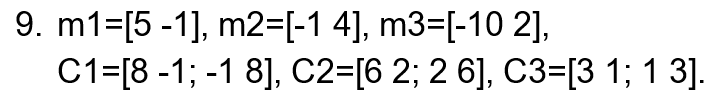

### 1. Задание исходных данных

In [200]:
import numpy as np
np.set_printoptions(precision= 5, suppress=False)

In [201]:
n = 2 #размерность признакового пространства
M = 3 #число классов
K = 10000 #количество статистических испытаний
dm = 2 #расстояние между матожиданиями вдоль координатных осей
pw = np.array([0.33, 0.34, 0.33]) #априорные вероятности классов
m = dm*np.matrix([[5, -1, -10], [-1, 4, 2]]) #матожидания (записаны как у Сироты)
C = np.array([[[8,6,3],[-1,2,1]], [[-1,2,1],[8,6,3]]]) #матрица ковариаций
C_ = np.zeros([n, n, M]) #матрица, обратная к матрице ковариаций
for i in range(M):
    C_[:,:, i]=np.linalg.inv(C[:,:,i])
D = np.array([[3, 1, 1], [1, 1, 5]])  #дисперсия (записано как у Сироты)

In [202]:
from numpy.linalg import cholesky
#Функция генерации совокупности гауссовских случайных векторов 
#с нулевым математическим ожиданием и матрицей ковариации С
#n-исходный порядок матрицы ковариации C (размер n*n)
#N-количество генерируемых векторов
def randncor(n,N,C):
    A=cholesky(C)
    m=n
    u=np.random.randn(m,N)
    x=np.transpose(A)*u
    return x

In [203]:
'''
XK=np.zeros((n, M*K))
for k in range(K):
    for i in range(M):
        x_ = randncor(n,1,C)
        XK[:n, (i-1)*K+k] = (m[:,i]+x_).ravel()
'''

'\nXK=np.zeros((n, M*K))\nfor k in range(K):\n    for i in range(M):\n        x_ = randncor(n,1,C)\n        XK[:n, (i-1)*K+k] = (m[:,i]+x_).ravel()\n'

### 2. Расчет разделяющих функций и вероятностей ошибок разпознавания

In [204]:
P_err =  np.zeros((M, M))
chernov_border =  np.zeros((M, M)) #граница Чернова
l0 = np.zeros((M,M))

In [205]:
from scipy.stats import norm
for i in range(M):
    for j in range(i+1, M):
        dm_ij=m[:,i]-m[:,j]
        l0[i,j]=np.log(pw[j]/pw[i])
        det_i=np.linalg.det(C[:,:,i]) 
        det_j=np.linalg.det(C[:,:,j])
        trace_ij=np.trace(C_[:,:,j]*C[:,:,i]-np.eye(n))
        trace_ji=np.trace(np.eye(n)-C_[:,:,i]*C[:,:,j])
        mg1=0.5*(trace_ij+np.transpose(dm_ij)*C_[:,:,j]*dm_ij-np.log(det_i/det_j))
        Dg1=0.5*trace_ij**2+np.transpose(dm_ij)*C_[:,:,j]*C[:,:,i]*C_[:,:,j]*dm_ij 
        mg2=0.5*(trace_ji-np.transpose(dm_ij)*C_[:,:,i]*dm_ij+np.log(det_j/det_i))
        Dg2=0.5*trace_ji**2+np.transpose(dm_ij)*C_[:,:,i]*C[:,:,j]*C_[:,:,i]*dm_ij
        sD1=np.sqrt(Dg1)
        sD2=np.sqrt(Dg2)
        P_err[i,j]=norm.cdf(l0[i,j],mg1,sD1)
        P_err[j,i]=1-norm.cdf(l0[i,j],mg2,sD2)
        mu=0.125*np.transpose(dm_ij)*np.transpose(C[:,:,i]+C[:,:,j])*0.5*dm_ij+\
        0.5*np.log((det_i+det_j)/(2*np.sqrt(det_i*det_j))) #расстояние Бхатачария      
        chernov_border[i,j]=np.sqrt(pw[j]/pw[i])*np.exp(-mu)
        chernov_border[j,i]=np.sqrt(pw[i]/pw[j])*np.exp(-mu)
    chernov_border[i,i]=1-np.sum(chernov_border[i,:])
    P_err[i,i]=1-np.sum(P_err[i,:])

In [206]:
np.set_printoptions(suppress=True)
print('Теоретическая матрица вероятностей ошибок:\n {0}'.format(P_err))

np.set_printoptions(suppress=True)
print('Матрица вероятностей ошибок на основе границы Чернова:\n {0}'.format(chernov_border))

Теоретическая матрица вероятностей ошибок:
 [[ 0.99544  0.00456  0.     ]
 [ 0.00005  0.99985  0.0001 ]
 [ 0.       0.       1.     ]]
Матрица вероятностей ошибок на основе границы Чернова:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


### 3.Тестирование алгоритма методом статистических испытаний

In [207]:
#Функция для вычисления экспериментальной матрицы ошибок
def experiment_error(K):
    x=np.matrix(np.ones((n, 1)))
    u=np.zeros((M, 1))
    P_err_experiment=np.zeros((M, M)) #экспериментальная матрица ошибок
    for k in range(K): #цикл по испытаниям
        for i in range(M): #цикл по классам
            x_=randncor(n, 1, C[:,:,i])
            x+=m[:,i] #генерация образа i-го класса
            for j in range(M): #вычисление значения разделяющих функций
                u[j]=-0.5*np.transpose(x-m[:,j])*C_[:,:,j]*(x-m[:,j])-\
                0.5*np.linalg.det(C[:,:,j])+np.log(pw[j])
            u_max=u.max() #определение максимума
            u_max_num=np.where(u==u_max)[0]
            P_err_experiment[i, u_max_num]+=1
    P_err_experiment/=K
    return P_err_experiment

In [208]:
sample_size=[10, 100, 1000]
errors=[experiment_error(i) for i in sample_size]

In [209]:
for i in range(len(sample_size)):
    print('Образов в одном классе: '+ format(sample_size[i]))
    print('Экспериментальная матрица ошибок:\n{0}\n'.format(errors[i]))

Образов в одном классе: 10
Экспериментальная матрица ошибок:
[[ 0.7  0.2  0.1]
 [ 0.7  0.3  0. ]
 [ 0.8  0.   0.2]]

Образов в одном классе: 100
Экспериментальная матрица ошибок:
[[ 0.97  0.02  0.01]
 [ 0.97  0.03  0.  ]
 [ 0.98  0.    0.02]]

Образов в одном классе: 1000
Экспериментальная матрица ошибок:
[[ 0.997  0.002  0.001]
 [ 0.997  0.003  0.   ]
 [ 0.998  0.     0.002]]

